In [1]:
import os
import pickle
import zipfile
import pandas as pd
import numpy as np
import neuralflow
from neuralflow.utilities.psth import extract_psth
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
from utils import select_neuron, single_unit_optimization
from utils_plot import plot_psth, plot_heatmap_tuning_curve
import warnings
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import re







### load the spike data of one example unit and plot the psth 

In [2]:
session_id = '20211020'
neuron_idx = 188
data = pd.read_json(f'dataset_single_unit/{session_id}/neuron_{neuron_idx}.json')
data['neuron_0'] = data['neuron_0'].apply(lambda x: np.array([x]) if isinstance(x, (int, float)) else np.array(x))
data = data[data['neuron_0'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
data.head()


,chosen_side,correct_response,stim_onset,RT,neuron_0,Coherence
0,left,left,1,0.333,"[0.769508333333305, 0.837141666666639, 1.12784...",0.512
1,left,left,1,0.470,"[1.054326075000062, 1.240321424999933, 2.05530...",0.512
2,right,right,1,0.379,"[0.712008781126087, 0.8607433539451671, 0.9115...",0.512
3,left,left,1,0.325,"[0.6399228400000531, 0.6800551700000591, 1.262...",0.512
4,right,right,1,0.330,"[0.90344994250006, 1.091045252500066, 2.173784...",0.512


/projectnb/ecog-eeg/cyw6/neuralflow/examples_Stine/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['spk_stim'] = data.apply(
/projectnb/ecog-eeg/cyw6/neuralflow/examples_Stine/utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['spk_sacc'] = data.apply(


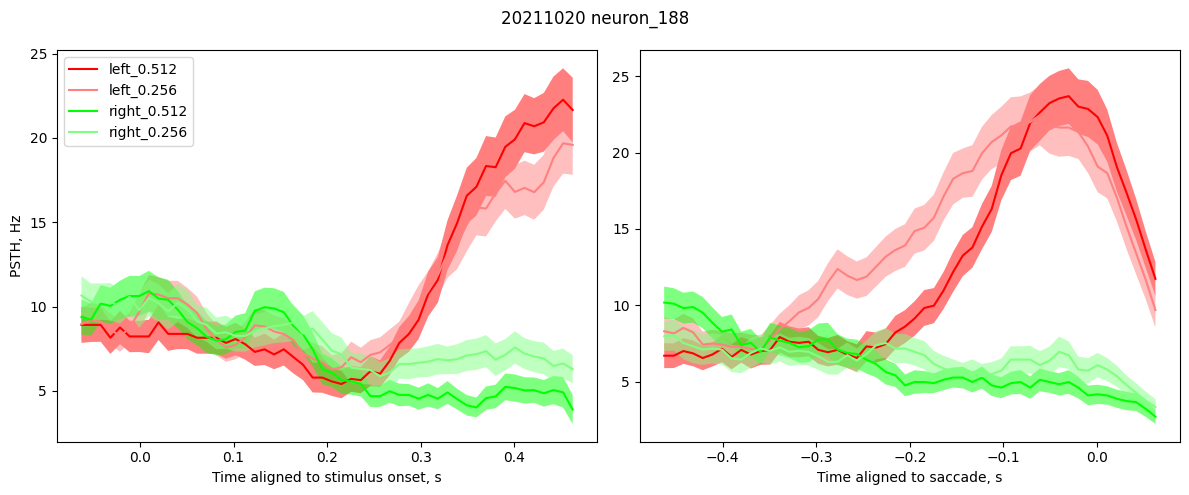

In [4]:
if select_neuron(data):
    plot_psth(data, neuron_id=f'neuron_{neuron_idx}', session_id=session_id)
else:
    print('Neuron not selected')


### perform the optimization

In [ ]:
max_epochs = 50
time_offset = 0.2
single_unit_optimization(df=data, time_offset=time_offset, max_epochs=max_epochs, 
                         device='CPU', save_path='optimization_results_single_unit', 
                         session_id=session_id, neuron_id=neuron_idx)

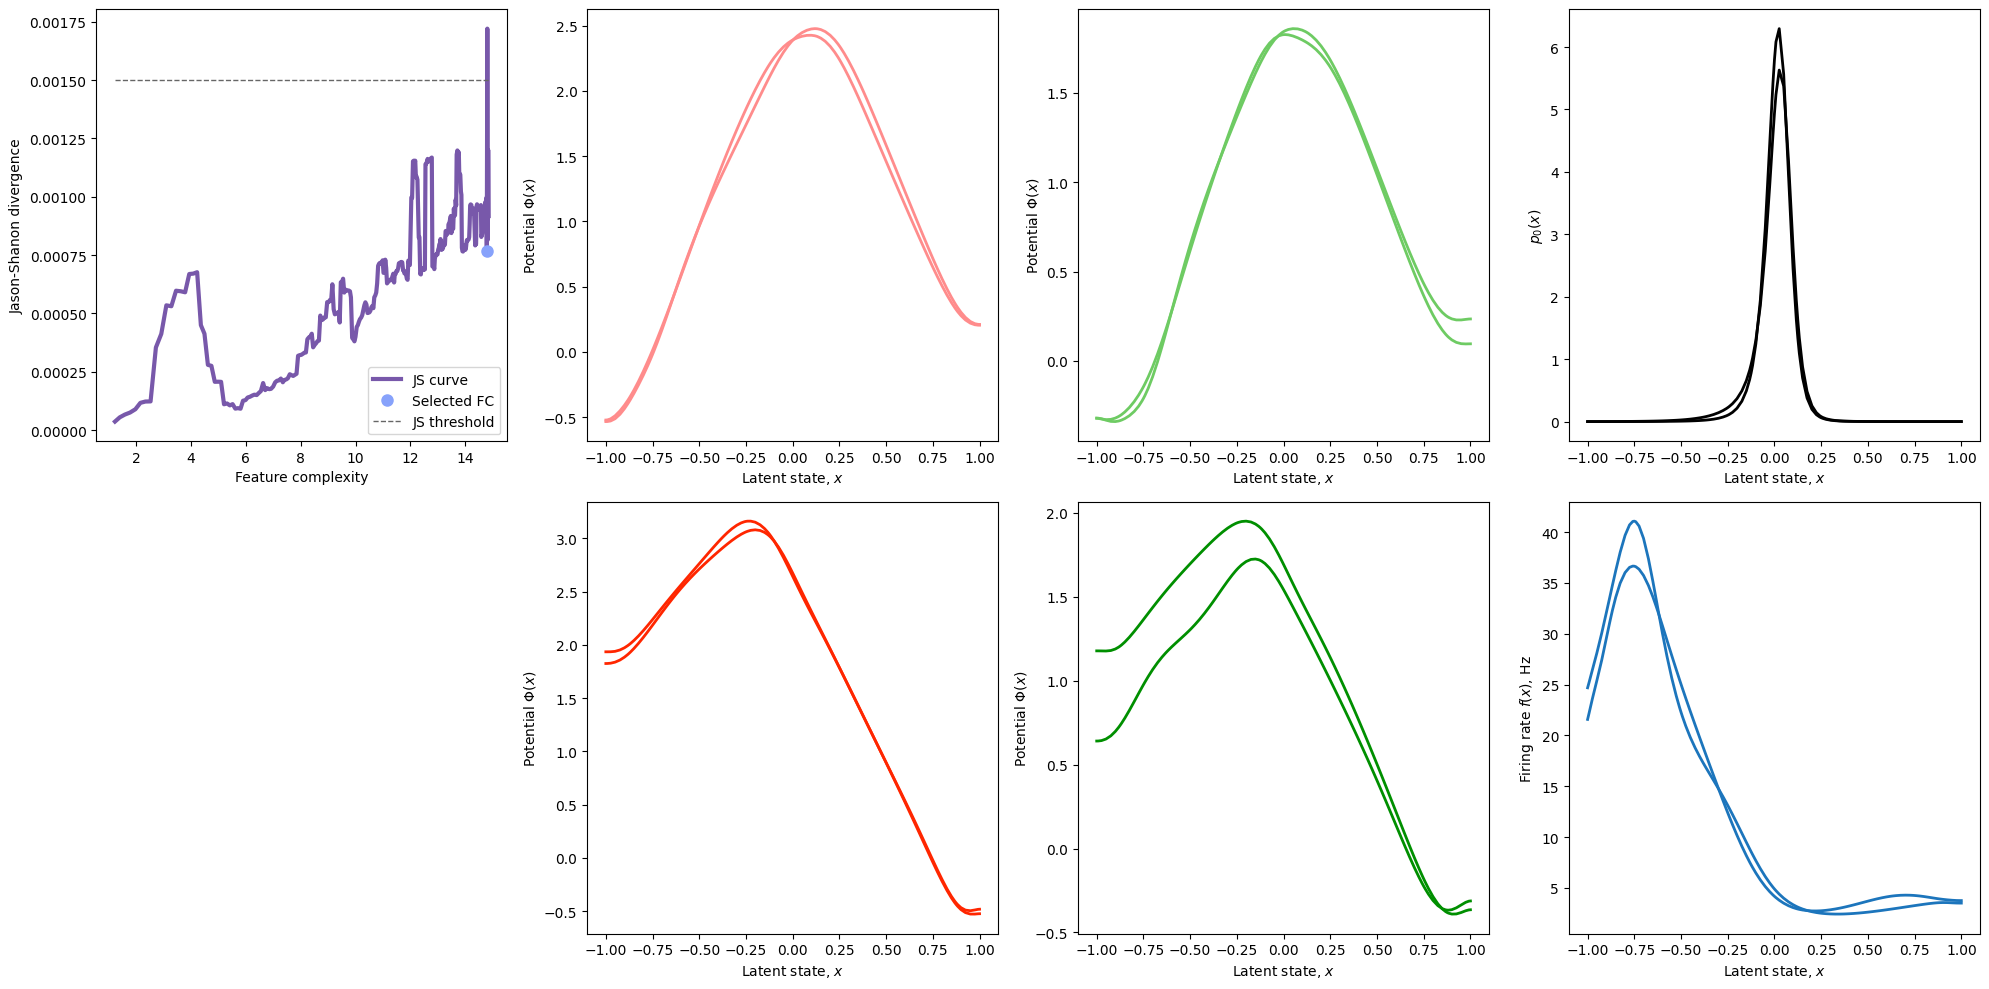

In [2]:
from utils import plot_optimization_results

session_id = '20211020'
neuron_idx = 188
plot_optimization_results(session_id=session_id, neuron_id=neuron_idx)

In [4]:
data_path = 'dataset_single_unit'

for session_id in (os.listdir(data_path)):
    print(os.listdir(os.path.join(data_path, session_id)))

['neuron_135.json', 'neuron_174.json', 'neuron_134.json', 'neuron_190.json', 'neuron_165.json', 'neuron_153.json', 'neuron_119.json', 'neuron_126.json', 'neuron_111.json', 'neuron_177.json', 'neuron_163.json', 'neuron_118.json', 'neuron_124.json', 'neuron_158.json', 'neuron_155.json', 'neuron_167.json', 'neuron_91.json', 'neuron_166.json', 'neuron_37.json', 'neuron_199.json', 'neuron_151.json', 'neuron_12.json', 'neuron_64.json', 'neuron_110.json', 'neuron_54.json', 'neuron_3.json', 'neuron_53.json', 'neuron_17.json', 'neuron_114.json', 'neuron_36.json', 'neuron_47.json', 'neuron_7.json', 'neuron_103.json', 'neuron_107.json', 'neuron_196.json', 'neuron_181.json', 'neuron_77.json', 'neuron_127.json', 'neuron_143.json', 'neuron_43.json', 'neuron_179.json', 'neuron_125.json', 'neuron_57.json', 'neuron_122.json', 'neuron_15.json', 'neuron_67.json', 'neuron_9.json', 'neuron_195.json', 'neuron_146.json', 'neuron_19.json', 'neuron_178.json', 'neuron_5.json', 'neuron_130.json', 'neuron_156.jso

### sort out all units that pass the test and plot the psth

In [53]:


warnings.filterwarnings('ignore')
data_path = 'dataset_single_unit'
unitIdx = {}
with PdfPages('figs/psth_all_units.pdf') as pdf:
    for session_id in tqdm(os.listdir(data_path)):
        unitIdx[session_id] = []
        for neuron_id in tqdm(os.listdir(os.path.join(data_path, session_id))):
            ### load the data
            with open(os.path.join(data_path, session_id, neuron_id), 'rb') as f:
                data = pd.read_json(f)
            ### convert the spike times to numpy array
            data['neuron_0'] = data['neuron_0'].apply(lambda x: np.array([x]) if isinstance(x, (int, float)) else np.array(x))

            ### select the neuron
            if select_neuron(data):
                neuron_id_num = int(re.search(r'neuron_(\d+)\.json', neuron_id).group(1))
                unitIdx[session_id].append(neuron_id_num)
                ### plot the psth
                fig = plot_psth(data, neuron_id=neuron_id, session_id=session_id)
                pdf.savefig(fig)
                plt.close(fig)
            else:
                pass
with open('unitIdx_all_sessions.pkl', 'wb') as f:
    pickle.dump(unitIdx, f)

100%|██████████| 8/8 [01:22<00:00, 10.28s/it]


### visualize the proprtion of decision-related neurons in each session


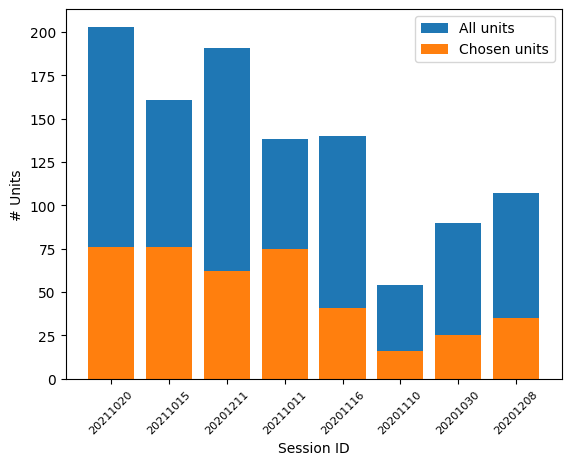

In [3]:
with open('unitIdx_all_sessions.pkl', 'rb') as f:
    unitIdx = pickle.load(f)

unit_num_all = []
unit_num_chosen = []
session_ids = []
for session_id in unitIdx:
    path = f'dataset_single_unit/{session_id}'
    unit_num = len(os.listdir(path))
    unit_num_all.append(unit_num)
    unit_num_chosen.append(len(unitIdx[session_id]))
    session_ids.append(session_id)




plt.bar(range(len(unit_num_all)), unit_num_all, label='All units')
plt.bar(range(len(unit_num_chosen)), unit_num_chosen, label='Chosen units')
plt.xticks(range(len(unit_num_all)), session_ids, fontsize=8, rotation=45)
plt.xlabel('Session ID')
plt.ylabel('# Units')
plt.legend()
plt.show()
    








### visualize the population tuning curves of all LIP neurons (combinings choice-selective units of all sessions)

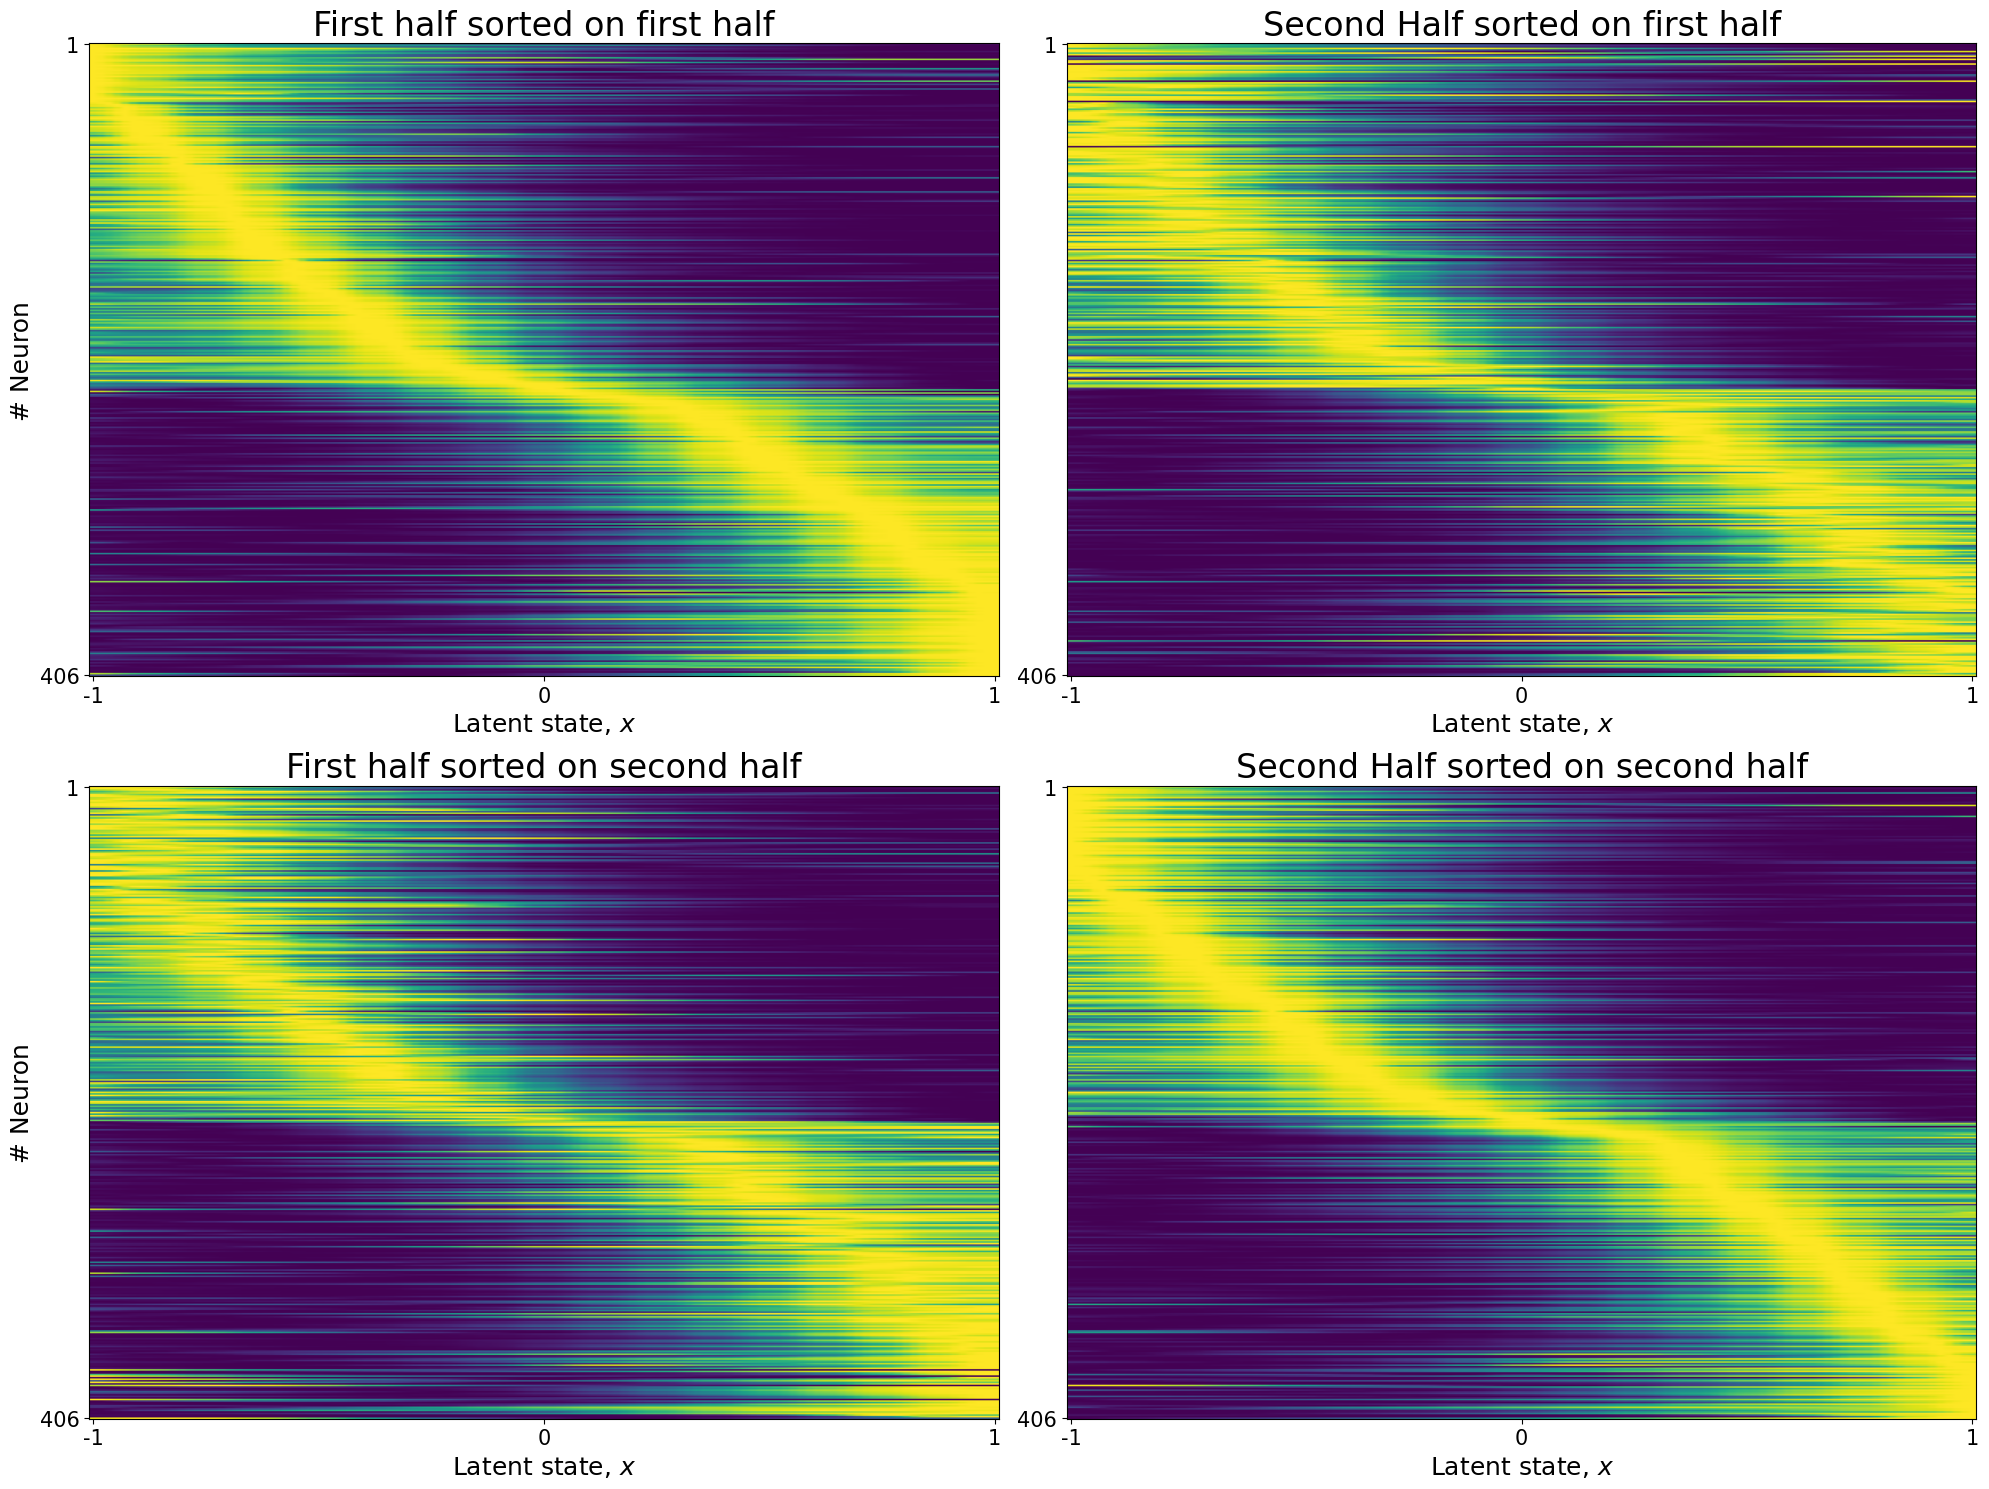

In [4]:
# Load data
res_path = 'optimization_results_single_unit'
with open('unitIdx_all_sessions.pkl', 'rb') as f:
    unitIdx = pickle.load(f)
res_files = [pickle.load(open(os.path.join(res_path, f), 'rb')) for f in os.listdir(res_path)]

fr_1_all = []
fr_2_all = []
### only keep the choice-selective units
for res in res_files:
    session_id = res['session_id']
    neuron_id = res['neuron_id']
    if neuron_id in unitIdx[session_id]:
        fr_1_all.append(res['fr_1'])
        fr_2_all.append(res['fr_2'][::-1 if res['invert'] else 1])

fr_1_all = np.array(fr_1_all)
fr_2_all = np.array(fr_2_all)

plot_heatmap_tuning_curve(fr_1_all, fr_2_all, if_save=False)


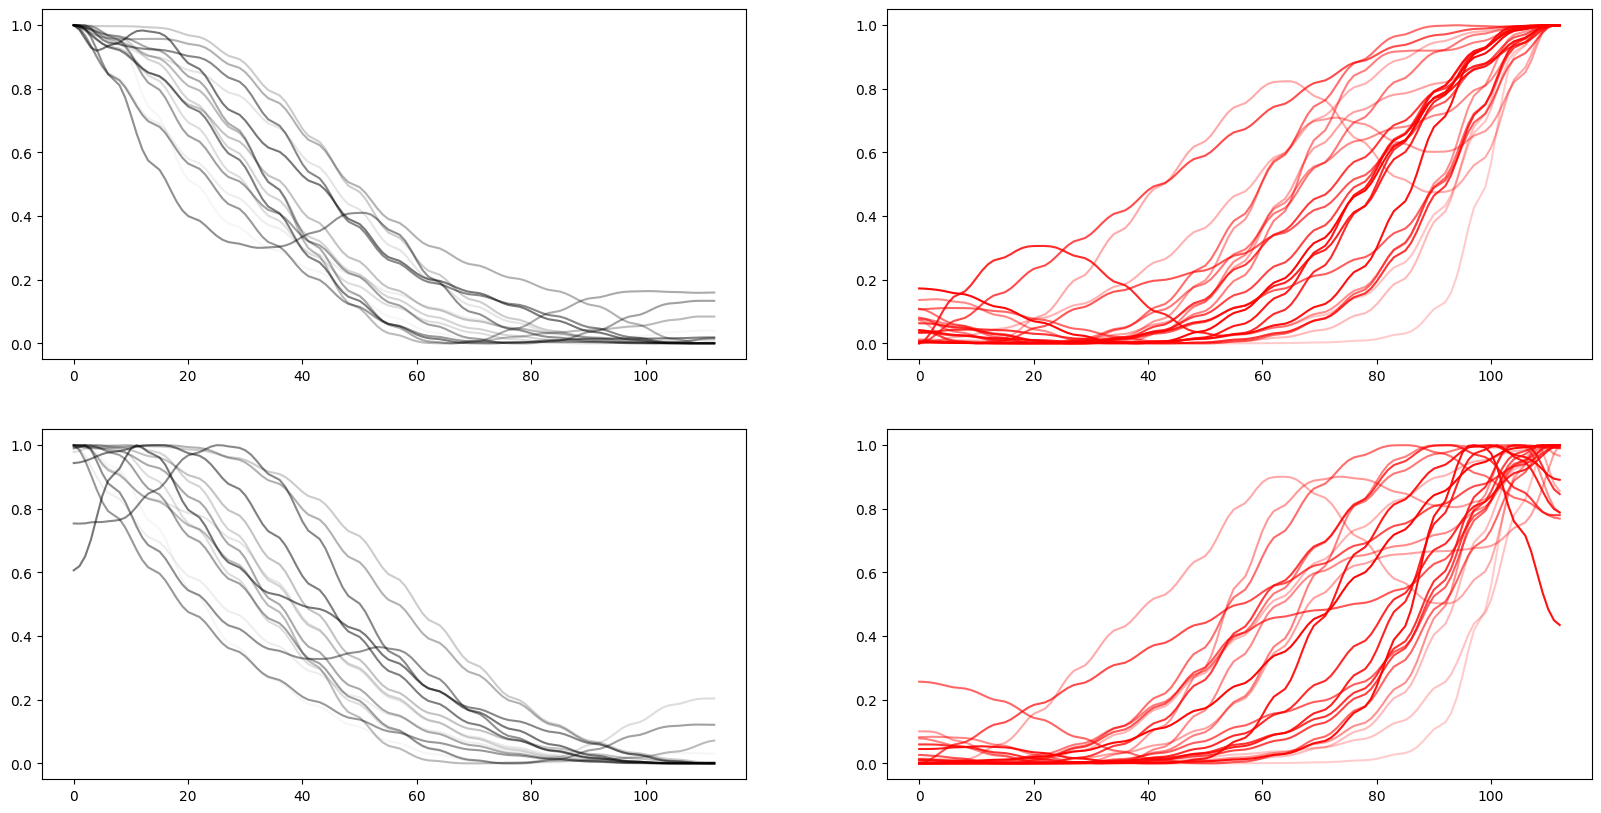

In [42]:
fr_1_all_norm = (fr_1_all - np.min(fr_1_all, axis=1)[:,np.newaxis]) / (np.max(fr_1_all, axis=1) - np.min(fr_1_all, axis=1))[:,np.newaxis]
fr_2_all_norm = (fr_2_all - np.min(fr_2_all, axis=1)[:,np.newaxis]) / (np.max(fr_2_all, axis=1) - np.min(fr_2_all, axis=1))[:,np.newaxis]
# Get peak times for each neuron
peak_times_1 = np.argmax(fr_1_all_norm, axis=1)
peak_times_2 = np.argmax(fr_2_all_norm, axis=1)
fr_1_all_norm = fr_1_all_norm[np.argsort(peak_times_1)]
fr_2_all_norm = fr_2_all_norm[np.argsort(peak_times_1)]

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
num_neurons = fr_1_all_norm.shape[0]
k = 0
for i in range(30):
    corr = np.corrcoef(fr_1_all_norm[i,:], fr_2_all_norm[i,:])[0,1]
    if fr_1_all_norm[i,-1] < 0.2 and corr > 0.9:
        k += 1
        ax[0,0].plot(fr_1_all_norm[i,:], c='black', alpha=k/30)
        ax[1,0].plot(fr_2_all_norm[i,:], c='black', alpha=k/30)

k = 0
for i in range(num_neurons-30, num_neurons):
    corr = np.corrcoef(fr_1_all_norm[i,:], fr_2_all_norm[i,:])[0,1]
    if fr_1_all_norm[i,0] < 0.2 and corr > 0.9:
        k += 1
        ax[0,1].plot(fr_1_all_norm[i,:], c='red', alpha=(30-k)/30)
        ax[1,1].plot(fr_2_all_norm[i,:], c='red', alpha=(30-k)/30)










# Plot the results

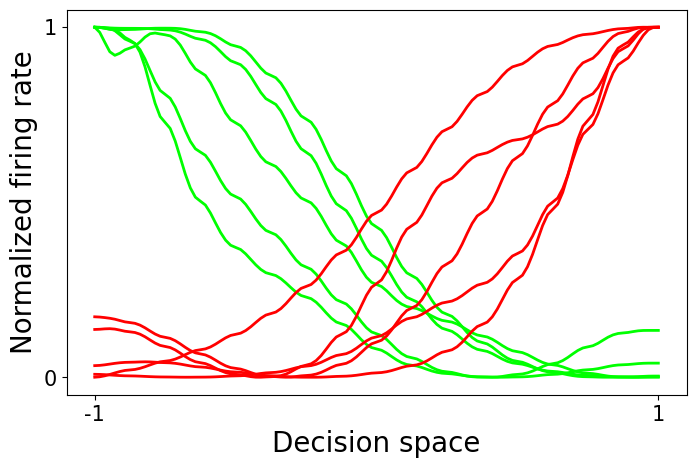

In [65]:
x_vals = np.arange(len(fr_1_all_norm[0,:]))
idx_exp_left = [i for i in range(50) if fr_1_all_norm[i,-1] < 0.2 and np.corrcoef(fr_1_all_norm[i,:], fr_2_all_norm[i,:])[0,1] > 0.9]
idx_exp_right = [i for i in range(num_neurons-30, num_neurons) if fr_1_all_norm[i,0] < 0.2 and np.corrcoef(fr_1_all_norm[i,:], fr_2_all_norm[i,:])[0,1] > 0.9]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for idx, i in enumerate([0, 14, 21, 28, 35]):
    ax.plot(fr_1_all_norm[i,:], c='#00FF00', linewidth=2)
    
for idx, i in enumerate([376, 384, 389, 395, 400]):
    ax.plot(fr_1_all_norm[i,:], c='#FF0000', linewidth=2)

ax.set_xlabel('Decision space', fontsize=20)
ax.set_ylabel('Normalized firing rate', fontsize=20)
ax.set_xticks([x_vals[0], x_vals[-1]], [-1, 1], fontsize=15)
ax.set_yticks([0, 1], [0, 1], fontsize=15)




In [57]:
idx_exp_right[::5]

[376, 384, 389, 395, 400]

### visualize the population tuning curves of LIP neurons from one session (simultaneously recorded)

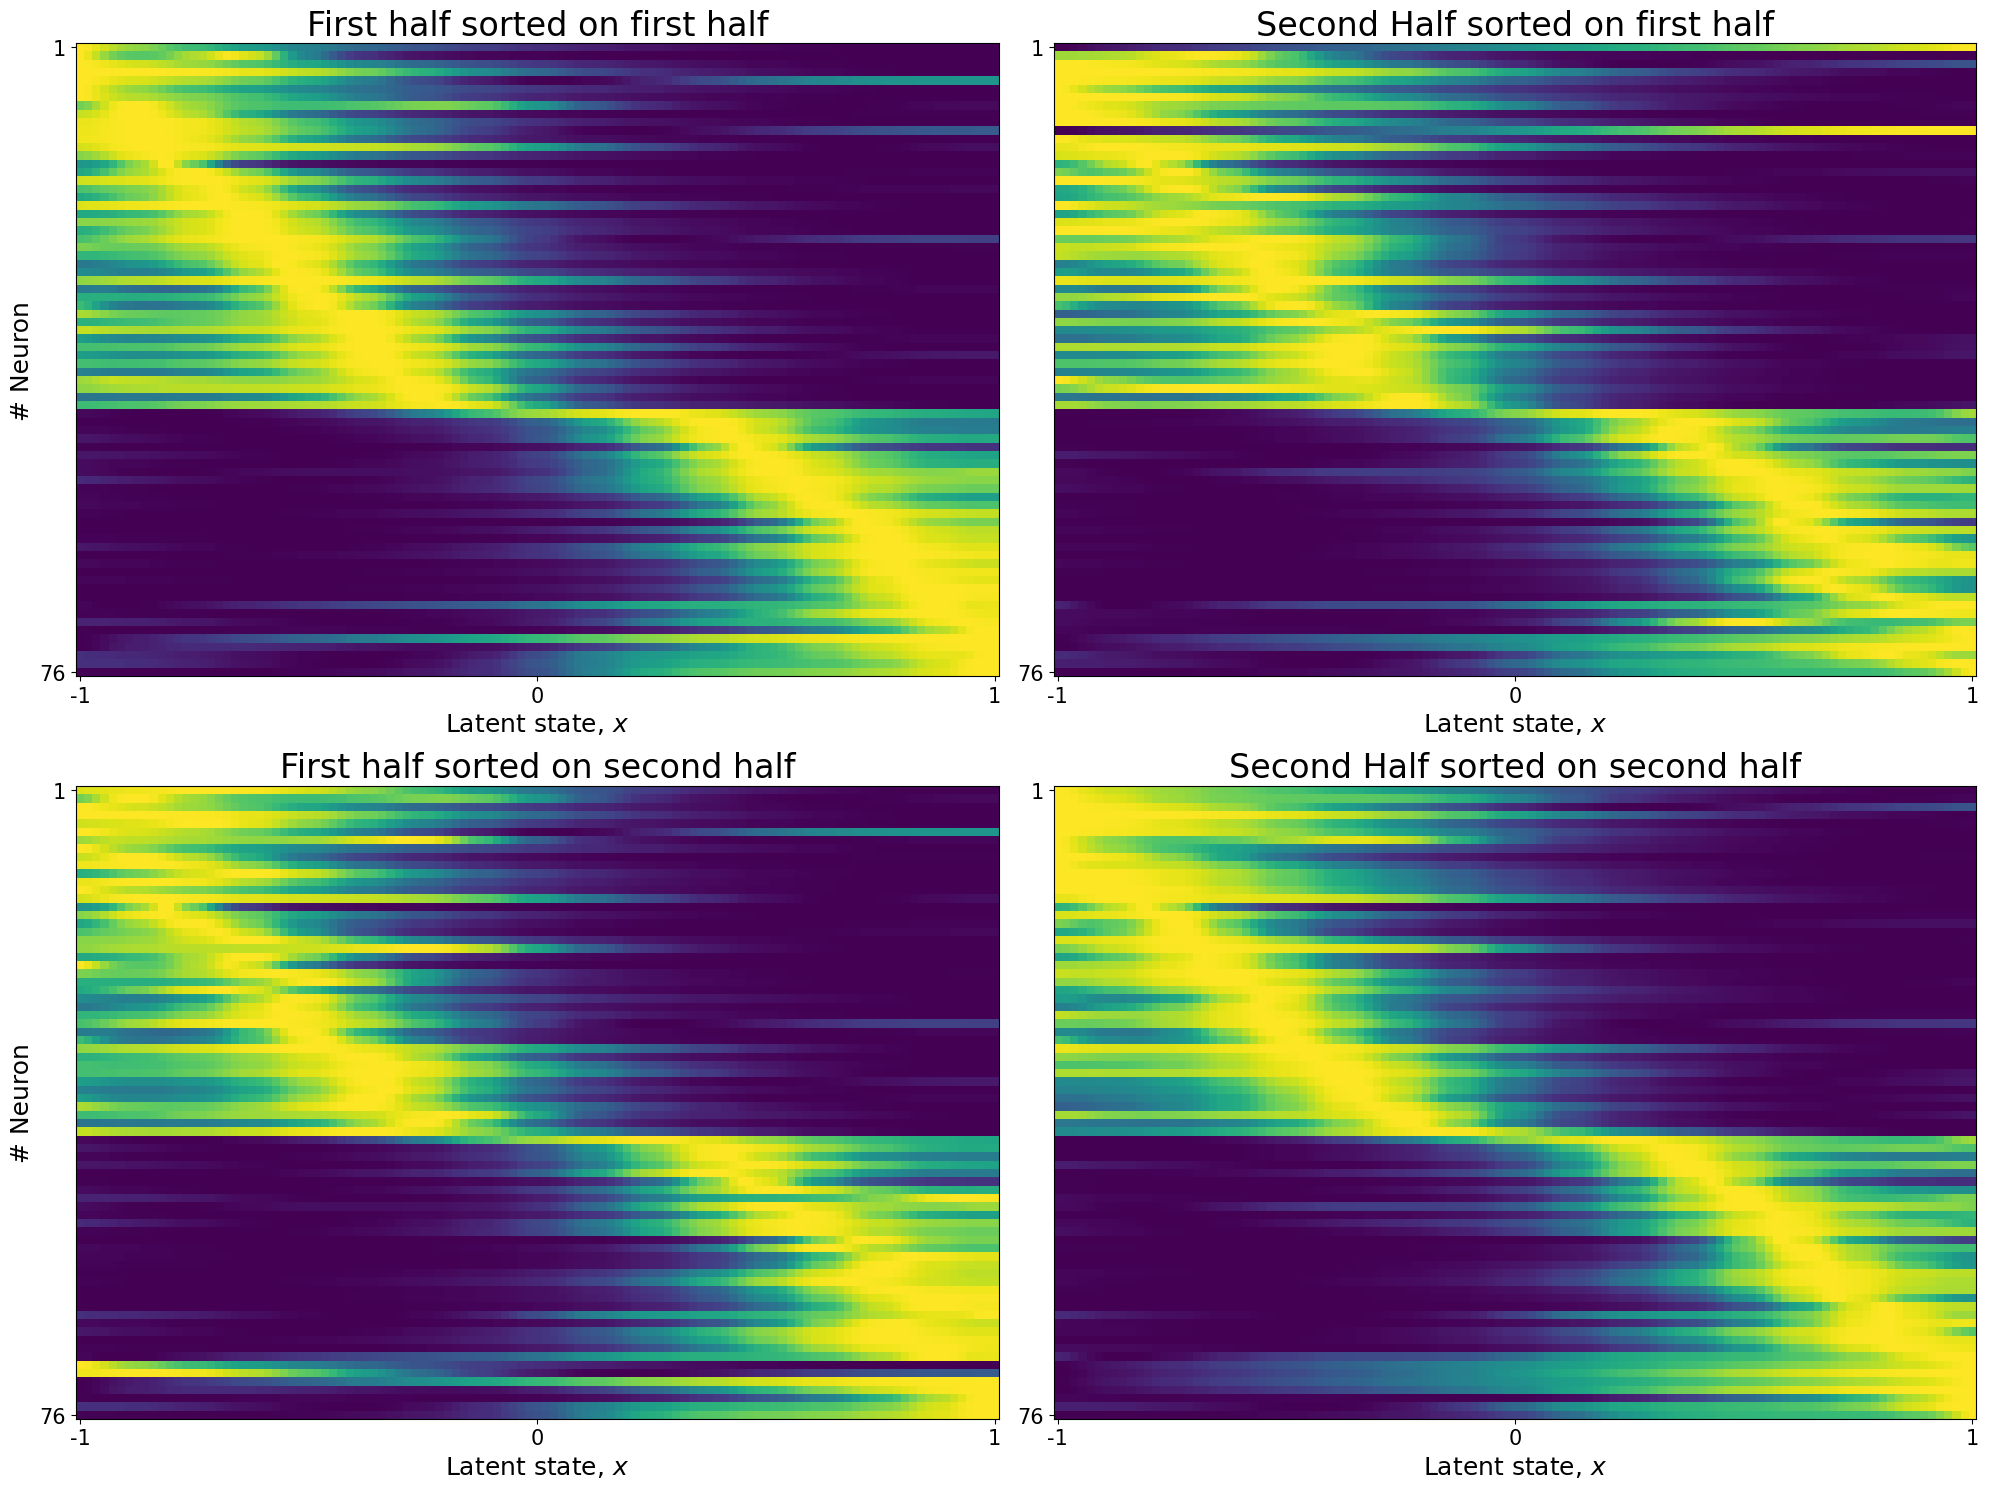

In [27]:
# Load data
res_path = 'optimization_results_single_unit'
chose_session_id = '20211015'

res_files = [pickle.load(open(os.path.join(res_path, f), 'rb')) for f in os.listdir(res_path)]


### only keep the choice-selective units
fr_1_all = []
fr_2_all = []
for res in res_files:
    session_id = res['session_id']
    neuron_id = res['neuron_id']
    if neuron_id in unitIdx[session_id] and res['session_id'] == chose_session_id:
        fr_1_all.append(res['fr_1'])
        fr_2_all.append(res['fr_2'][::-1 if res['invert'] else 1])

fr_1_all = np.array(fr_1_all)
fr_2_all = np.array(fr_2_all)



plot_heatmap_tuning_curve(fr_1_all, fr_2_all, if_save=False)